# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Задачи проекта
### Шаг 1. [Открыть файл с данными и изучить общую информацию](#step1)

### Шаг 2. [Провести предобработку данных](#step2)
 - определить и изучить пропущенные значения;
 - заполнить пропуски, где это уместно;
 - указать причины, которые могли привести к пропускам в данных;
 - привести данные к нужным типам.

### Шаг 3. [Посчитать и добавить в таблицу:](#step3)
 - цену квадратного метра;
 - день недели, месяц и год публикации объявления;
 - этаж квартиры; варианты — первый, последний, другой;
 - соотношение жилой и общей площади, а также отношение площади кухни к общей.

### Шаг 4. [Провести исследовательский анализ данных:](#step4)
 - изучить следующие параметры: площадь, цена, число комнат, высота потолков;
 - [изучить время продажи квартиры](#step4-1); 
 - [убрать редкие и выбивающиеся значения](#step4-2);
 - [определиться, какие факторы больше всего влияют на стоимость квартиры](#step4-3);
 - [выбрать 10 населённых пунктов с наибольшим числом объявлений, и посчитать среднюю цену квадратного метра в этих населённых пунктах](#step4-4);
 - [изучить предложения квартир в центре Санкт-Петербурга и выяснить, как цена зависит от удалённости от центра](#step4-5);
 - [выделить сегмент квартир в центре и проанализировать эту территорию](#step4-6).

### Шаг 5. [Написать общий вывод](#step5)

# Этапы выполнения проекта

### Шаг 1. Откройте файл с данными и изучите общую информацию. <a id='step1'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Оставим два нуля после точки для данных в таблице

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

Посмотрим на уникальные значения в столбцах

In [4]:
columns_names = df.columns.tolist()
print(columns_names)
for column_name in columns_names:
    print('Уникальные значения в столбце:', column_name,' - ',df[column_name].unique())
print('Количество дубликатов:', df.duplicated().sum())

['total_images', 'last_price', 'total_area', 'first_day_exposition', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor', 'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony', 'locality_name', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']
Уникальные значения в столбце: total_images  -  [20  7 10  0  2  6  5 18  9  1 16 11  8 12 13  3 15 17 14 19 32  4 35 39
 23 21 27 30 24 25 28 31 22 29 26 50 42 37]
Уникальные значения в столбце: last_price  -  [13000000.  3350000.  5196000. ...  6151120. 21400000. 11475000.]
Уникальные значения в столбце: total_area  -  [108.    40.4   56.   ...  66.86 133.81  76.75]
Уникальные значения в столбце: first_day_exposition  -  ['2019-03-07T00:00:00' '2018-12-04T00:00:00' '2015-08-20T00:00:00' ...
 '2014-12-29T00:00:00' '2016-09-12T00:00:00' '2015-07-19T00:00:00']
Уникальные значения в столбце: rooms  -  [ 3  1  2  4  5  6  0  7 11  8 14 10 1

Взглянем на статистические данные

In [5]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,"23,699.00","23,699.00","23,699.00","23,699.00","14,504.00","23,613.00","21,796.00","23,699.00","21,421.00","12,180.00","18,157.00","18,180.00","18,181.00","8,079.00","18,181.00","9,110.00","20,518.00"
mean,9.86,"6,541,548.77",60.35,2.07,2.77,10.67,34.46,5.89,10.57,1.15,"28,793.67","14,191.28",0.61,490.80,0.77,517.98,180.89
std,5.68,"10,887,013.27",35.65,1.08,1.26,6.60,22.03,4.89,5.91,1.07,"12,630.88","8,608.39",0.80,342.32,0.94,277.72,219.73
min,0.00,"12,190.00",12.00,0.00,1.00,1.00,2.00,1.00,1.30,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,"3,400,000.00",40.00,1.00,2.52,5.00,18.60,2.00,7.00,0.00,"18,585.00","9,238.00",0.00,288.00,0.00,294.00,45.00
50%,9.00,"4,650,000.00",52.00,2.00,2.65,9.00,30.00,4.00,9.10,1.00,"26,726.00","13,098.50",0.00,455.00,1.00,502.00,95.00
75%,14.00,"6,800,000.00",69.90,3.00,2.80,16.00,42.30,8.00,12.00,2.00,"37,273.00","16,293.00",1.00,612.00,1.00,729.00,232.00
max,50.00,"763,000,000.00",900.00,19.00,100.00,60.00,409.70,33.00,112.00,5.00,"84,869.00","65,968.00",3.00,"3,190.00",3.00,"1,344.00","1,580.00"


In [6]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


In [7]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,nan,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,nan
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,nan,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,nan,0.00,nan,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,nan,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,nan,14.00,nan,9,NaN,...,nan,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,nan,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


In [8]:
df.tail()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23694,9,"9,700,000.00",133.81,2017-03-21T00:00:00,3,3.70,5.00,73.30,3,NaN,...,13.83,nan,Санкт-Петербург,"24,665.00","4,232.00",1.00,796.00,3.00,381.00,nan
23695,14,"3,100,000.00",59.00,2018-01-15T00:00:00,3,nan,5.00,38.00,4,NaN,...,8.50,nan,Тосно,nan,nan,nan,nan,nan,nan,45.00
23696,18,"2,500,000.00",56.70,2018-02-11T00:00:00,2,nan,3.00,29.70,1,NaN,...,nan,nan,село Рождествено,nan,nan,nan,nan,nan,nan,nan
23697,13,"11,475,000.00",76.75,2017-03-28T00:00:00,2,3.00,17.00,nan,12,NaN,...,23.30,2.00,Санкт-Петербург,"39,140.00","10,364.00",2.00,173.00,3.00,196.00,602.00
23698,4,"1,350,000.00",32.30,2017-07-21T00:00:00,1,2.50,5.00,12.30,1,NaN,...,9.00,nan,поселок Новый Учхоз,nan,nan,nan,nan,nan,nan,nan


In [9]:
df.sample()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
15372,4,"4,200,000.00",32.00,2018-08-28T00:00:00,1,2.50,9.00,17.00,3,NaN,...,7.50,nan,Санкт-Петербург,"45,129.00","17,854.00",0.00,nan,0.00,nan,37.00


Посмотрим подробнее на заинтересовавшие столбцы, где встречаются странные значения (низкая/высокая высота потолков, количество комнат равно 0.

In [10]:
print(df['ceiling_height'].value_counts())

2.50      3515
2.60      1646
2.70      1574
3.00      1112
2.80       993
          ... 
27.50        1
5.00         1
3.59         1
4.80         1
100.00       1
Name: ceiling_height, Length: 183, dtype: int64


In [11]:
print(df['rooms'].value_counts())

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
14       2
11       2
19       1
12       1
16       1
15       1
Name: rooms, dtype: int64


### Вывод

После изучения датасета обнаружены следующие проблемы:
 - ОЧЕНЬ много пропусков в разных столбцах
 - в столбце rooms есть значение 0, что скорей всего ошибочно, и требует боле глубокого анализа.
 - в столбце ceiling_height есть ошибочно большие значения, которые не могут соответствовать реальности, например высота потолков равняется 25,26, 27, 100 метров.
 - неявные дубликаты местоположений (есть кудрово и деревня кудрово...)
 - неудобный порядок столбцов (однородные данные разбросаны друг от друга)
 
Будем потихоньку причесывать нашу таблицу)

 
 

### Шаг 2. Предобработка данных<a id='step2'></a>

Начнем с расстановки порядка столбцов.

In [12]:
df = df[['first_day_exposition','days_exposition','last_price','locality_name',
         'is_apartment','studio','open_plan','ceiling_height','floors_total','floor','rooms',
         'balcony','total_area','living_area','kitchen_area','airports_nearest','cityCenters_nearest',
         'parks_around3000','parks_nearest','ponds_around3000','ponds_nearest','total_images']]
df

,first_day_exposition,days_exposition,last_price,locality_name,is_apartment,studio,open_plan,ceiling_height,floors_total,floor,...,total_area,living_area,kitchen_area,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images
0,2019-03-07T00:00:00,nan,"13,000,000.00",Санкт-Петербург,NaN,False,False,2.70,16.00,8,...,108.00,51.00,25.00,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,20
1,2018-12-04T00:00:00,81.00,"3,350,000.00",посёлок Шушары,NaN,False,False,nan,11.00,1,...,40.40,18.60,11.00,"12,817.00","18,603.00",0.00,nan,0.00,nan,7
2,2015-08-20T00:00:00,558.00,"5,196,000.00",Санкт-Петербург,NaN,False,False,nan,5.00,4,...,56.00,34.30,8.30,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,10
3,2015-07-24T00:00:00,424.00,"64,900,000.00",Санкт-Петербург,NaN,False,False,nan,14.00,9,...,159.00,nan,nan,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,0
4,2018-06-19T00:00:00,121.00,"10,000,000.00",Санкт-Петербург,NaN,False,False,3.03,14.00,13,...,100.00,32.00,41.00,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,2017-03-21T00:00:00,nan,"9,700,000.00",Санкт-Петербург,NaN,False,False,3.70,5.00,3,...,133.81,73.30,13.83,"24,665.00","4,232.00",1.00,796.00,3.00,381.00,9
23695,2018-01-15T00:00:00,45.00,"3,100,000.00",Тосно,NaN,False,False,nan,5.00,4,...,59.00,38.00,8.50,nan,nan,nan,nan,nan,nan,14
23696,2018-02-11T00:00:00,nan,"2,500,000.00",село Рождествено,NaN,False,False,nan,3.00,1,...,56.70,29.70,nan,nan,nan,nan,nan,nan,nan,18
23697,2017-03-28T00:00:00,602.00,"11,475,000.00",Санкт-Петербург,NaN,False,False,3.00,17.00,12,...,76.75,nan,23.30,"39,140.00","10,364.00",2.00,173.00,3.00,196.00,13


Заменим пропуски на ноль в столбце с количеством балконов.

In [13]:
df['balcony'] = df['balcony'].fillna(0)
print(df['balcony'].value_counts())

0.00    15277
1.00     4195
2.00     3659
5.00      304
4.00      183
3.00       81
Name: balcony, dtype: int64


Разберемся со столбцом locality_name. Как было сказано выше, мы заметили, что часть населенных пунктов дублируется. Поэтому чтобы убрать дубликаты, мы обрежем названия типов городского пункта вида "поселок, деревня и т.д.". К тому же, заменим встречающийся символ "ё" на "е".

In [14]:
print(len(df['locality_name'].unique()))
df['locality_name'] = df['locality_name'].astype(str)
df['locality_name'] = df['locality_name'].replace('ё', 'е', regex=True).str.lower()
df['locality_name'] = df['locality_name'].replace('поселок ', '', regex=True)
df['locality_name'] = df['locality_name'].replace('деревня ', '', regex=True)
df['locality_name'] = df['locality_name'].replace('городского типа ', '', regex=True)
df['locality_name'] = df['locality_name'].replace('коттеджный ', '', regex=True)

print(len(df['locality_name'].unique()))
df.info()

365
321
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
first_day_exposition    23699 non-null object
days_exposition         20518 non-null float64
last_price              23699 non-null float64
locality_name           23699 non-null object
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
floor                   23699 non-null int64
rooms                   23699 non-null int64
balcony                 23699 non-null float64
total_area              23699 non-null float64
living_area             21796 non-null float64
kitchen_area            21421 non-null float64
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds

Как видно, количество уникальных значений уменьшилось с 365 до 321.

Внесем изменения в столбец  is_apartment. Поскольку в нашем задании говорилось о том, что мы работаем с жилыми квартирами, то заменим пустые значения на значение False.

In [15]:
df['is_apartment'] = df['is_apartment'].fillna(False)
df['is_apartment'].value_counts()

False    23649
True        50
Name: is_apartment, dtype: int64

Разберемся с квартирами, у которых стоит значение 0 в столбце "rooms".

In [16]:
print(df[df['rooms'] == 0]['total_area'].describe())
print(df[df['rooms'] == 1]['total_area'].describe())
print(df[df['rooms'] == 0]['total_area'].sort_values(ascending = False).head(10))

count   197.00
mean     29.28
std      25.86
min      15.50
25%      24.05
50%      26.05
75%      28.40
max     371.00
Name: total_area, dtype: float64
count   8,047.00
mean       37.64
std         9.34
min        12.00
25%        32.50
50%        36.56
75%        41.00
max       494.10
Name: total_area, dtype: float64
19392   371.00
20082    98.40
3458     73.60
21227    71.00
13613    58.40
10008    44.20
15319    43.30
7237     42.63
16130    42.10
9052     38.30
Name: total_area, dtype: float64


В целом значения равные 0 - неошибочные, поскольку данные отличаются от квартир с одной комнатной. Но также есть выброс - квартира с площадью 371 и 494 метра. Трогать их пока не будем. 

Удалим строки с пустыми значениями в floors_total, поскольку количество строк всего 86 (составляет малый процент от всех данных)

In [17]:
df.query('floors_total == "Nan"').count() 
df.dropna(subset = ['floors_total'],inplace = True)
df = df.reset_index(drop= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23613 entries, 0 to 23612
Data columns (total 22 columns):
first_day_exposition    23613 non-null object
days_exposition         20441 non-null float64
last_price              23613 non-null float64
locality_name           23613 non-null object
is_apartment            23613 non-null bool
studio                  23613 non-null bool
open_plan               23613 non-null bool
ceiling_height          14495 non-null float64
floors_total            23613 non-null float64
floor                   23613 non-null int64
rooms                   23613 non-null int64
balcony                 23613 non-null float64
total_area              23613 non-null float64
living_area             21743 non-null float64
kitchen_area            21382 non-null float64
airports_nearest        18081 non-null float64
cityCenters_nearest     18104 non-null float64
parks_around3000        18105 non-null float64
parks_nearest           8045 non-null float64
ponds_around30

Разберемся с пустыми значениями в ceiling_height. Зададим им средные значения исходя из этажности дома.

In [18]:
df['ceiling_height'] = df['ceiling_height'].fillna(df.groupby('floors_total')['ceiling_height'].transform('mean'))
df['ceiling_height'].describe()

count   23,612.00
mean         2.77
std          0.99
min          1.00
25%          2.60
50%          2.71
75%          2.79
max        100.00
Name: ceiling_height, dtype: float64

На данном этапе закончим работу с пустыми значениями. Если потребуется их заполнить в других задачах, то сделаем это позже.

А пока заменим типы данных у следующих полей для оптимизации использования памяти:
 - first_day_exposition - на datetime
 - is_apartment - на bool
 - floors_total - на int16
 - balcony - на int16
 - floors - на int16
 - rooms - на int16
 - ceiling_height - на float16

In [19]:
df['is_apartment'].astype('bool') 
df['balcony'] = df['balcony'].astype('int16') 
df['floors_total'] = df['floors_total'].astype('int16') 
df['floor'] = df['floor'].astype('int16')
df['rooms'] = df['rooms'].astype('int16')
df['ceiling_height'] = df['ceiling_height'].astype('float16')
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23613 entries, 0 to 23612
Data columns (total 22 columns):
first_day_exposition    23613 non-null datetime64[ns]
days_exposition         20441 non-null float64
last_price              23613 non-null float64
locality_name           23613 non-null object
is_apartment            23613 non-null bool
studio                  23613 non-null bool
open_plan               23613 non-null bool
ceiling_height          23612 non-null float16
floors_total            23613 non-null int16
floor                   23613 non-null int16
rooms                   23613 non-null int16
balcony                 23613 non-null int16
total_area              23613 non-null float64
living_area             21743 non-null float64
kitchen_area            21382 non-null float64
airports_nearest        18081 non-null float64
cityCenters_nearest     18104 non-null float64
parks_around3000        18105 non-null float64
parks_nearest           8045 non-null float64
ponds_arou

,first_day_exposition,days_exposition,last_price,locality_name,is_apartment,studio,open_plan,ceiling_height,floors_total,floor,...,total_area,living_area,kitchen_area,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images
0,2019-03-07,nan,"13,000,000.00",санкт-петербург,False,False,False,2.70,16,8,...,108.00,51.00,25.00,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,20
1,2018-12-04,81.00,"3,350,000.00",шушары,False,False,False,2.78,11,1,...,40.40,18.60,11.00,"12,817.00","18,603.00",0.00,nan,0.00,nan,7
2,2015-08-20,558.00,"5,196,000.00",санкт-петербург,False,False,False,2.79,5,4,...,56.00,34.30,8.30,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,10
3,2015-07-24,424.00,"64,900,000.00",санкт-петербург,False,False,False,2.73,14,9,...,159.00,nan,nan,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,0
4,2018-06-19,121.00,"10,000,000.00",санкт-петербург,False,False,False,3.03,14,13,...,100.00,32.00,41.00,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,2


Заменим пустые значения в столбцах living_area и kitchen_area. Для этого посчитаем среднее одношение данных столбцов от общенй площади.

In [20]:
living_area_mean = df['total_area'].mean() / df['living_area'].mean()
print(living_area_mean)
kitchen_area_mean = df['total_area'].mean() / df['kitchen_area'].mean()
print(kitchen_area_mean)


1.7508940470966243
5.7118467087607865


In [21]:
df['living_area'].fillna(df['total_area']/living_area_mean, inplace = True)
df['kitchen_area'].fillna(df['total_area']/kitchen_area_mean, inplace = True)
df.head()

,first_day_exposition,days_exposition,last_price,locality_name,is_apartment,studio,open_plan,ceiling_height,floors_total,floor,...,total_area,living_area,kitchen_area,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images
0,2019-03-07,nan,"13,000,000.00",санкт-петербург,False,False,False,2.70,16,8,...,108.00,51.00,25.00,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,20
1,2018-12-04,81.00,"3,350,000.00",шушары,False,False,False,2.78,11,1,...,40.40,18.60,11.00,"12,817.00","18,603.00",0.00,nan,0.00,nan,7
2,2015-08-20,558.00,"5,196,000.00",санкт-петербург,False,False,False,2.79,5,4,...,56.00,34.30,8.30,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,10
3,2015-07-24,424.00,"64,900,000.00",санкт-петербург,False,False,False,2.73,14,9,...,159.00,90.81,27.84,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,0
4,2018-06-19,121.00,"10,000,000.00",санкт-петербург,False,False,False,3.03,14,13,...,100.00,32.00,41.00,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,2


In [22]:
df.describe()

,days_exposition,last_price,ceiling_height,floors_total,floor,rooms,balcony,total_area,living_area,kitchen_area,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images
count,"20,441.00","23,613.00","23,612.00","23,613.00","23,613.00","23,613.00","23,613.00","23,613.00","23,613.00","23,613.00","18,081.00","18,104.00","18,105.00","8,045.00","18,105.00","9,061.00","23,613.00"
mean,180.88,"6,540,555.46",2.77,10.67,5.88,2.07,0.59,60.34,34.60,10.50,"28,788.01","14,185.08",0.61,490.55,0.77,518.21,9.87
std,219.69,"10,901,722.74",0.99,6.60,4.87,1.08,0.96,35.65,22.37,6.04,"12,626.21","8,614.13",0.80,341.34,0.94,277.89,5.68
min,1.00,"12,190.00",1.00,1.00,1.00,0.00,0.00,12.00,2.00,1.30,0.00,181.00,0.00,1.00,0.00,13.00,0.00
25%,45.00,"3,400,000.00",2.60,5.00,2.00,1.00,0.00,40.00,19.00,7.00,"18,575.00","9,233.75",0.00,288.00,0.00,294.00,6.00
50%,95.00,"4,650,000.00",2.71,9.00,4.00,2.00,0.00,52.00,30.00,9.00,"26,726.00","13,093.00",0.00,455.00,1.00,503.00,9.00
75%,232.00,"6,799,000.00",2.79,16.00,8.00,3.00,1.00,69.80,42.10,12.00,"37,242.00","16,287.00",1.00,612.00,1.00,730.00,14.00
max,"1,580.00","763,000,000.00",100.00,60.00,33.00,19.00,5.00,900.00,409.70,112.00,"84,869.00","65,968.00",3.00,"3,190.00",3.00,"1,344.00",50.00


In [23]:
df[['last_price',
    'airports_nearest',
    'cityCenters_nearest',
    'parks_around3000',
    'parks_nearest',
    'ponds_around3000',
    'ponds_nearest']].corr()

,last_price,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
last_price,1.00,-0.03,-0.21,0.15,-0.02,0.16,-0.09
airports_nearest,-0.03,1.00,0.27,0.00,-0.07,-0.05,0.01
cityCenters_nearest,-0.21,0.27,1.00,-0.16,-0.04,-0.07,0.03
parks_around3000,0.15,0.00,-0.16,1.00,-0.26,0.30,-0.17
parks_nearest,-0.02,-0.07,-0.04,-0.26,1.00,0.07,0.00
ponds_around3000,0.16,-0.05,-0.07,0.30,0.07,1.00,-0.34
ponds_nearest,-0.09,0.01,0.03,-0.17,0.00,-0.34,1.00


Посмотрев корреляцию мы не выявили заявисимость оставшихся пустых данных. Поэтому заполнить их в ручную будет неправильно - это сможет сказаться на финальном результате. Необходимо проводить проверку данных при выгрузке в файл, чтобыв данных столбцах не было пустых значений.

### Шаг 3. Посчитайте и добавьте в таблицу<a id='step1'></a>

 Посчитаем и добавим в таблицу следующие столбцы:
  - цену квадратного метра
  - день недели, месяц и год публикации публикации
  - этаж квартиры, варианты первый, последний или другой.
  - соотношение жилой и общей площади, а также отношение кухний к общей.

In [24]:
df['price_per_metre'] = df['last_price']/df['total_area']

In [25]:
df['day_exposition'] = df['first_day_exposition'].dt.day_name()
df['month_exposition'] = df['first_day_exposition'].dt.month_name()
df['year_exposition'] = pd.DatetimeIndex(df['first_day_exposition']).year 

In [26]:
def category_floor(row):
    if row['floor'] == row['floors_total']:
        return 'последний'
    elif row['floor'] == 1:
        return 'первый'
    else:
        return 'другой'
df['category_floor'] = df.apply(category_floor, axis=1)
print(df['category_floor'])

        

0        другой
1        первый
2        другой
3        другой
4        другой
          ...  
23608    другой
23609    другой
23610    первый
23611    другой
23612    первый
Name: category_floor, Length: 23613, dtype: object


In [27]:
df['relation_living_total'] = df['living_area']/df['total_area']
df['relation_kitchen_total'] = df['kitchen_area']/df['total_area']

In [28]:
df.describe()

,days_exposition,last_price,ceiling_height,floors_total,floor,rooms,balcony,total_area,living_area,kitchen_area,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_per_metre,year_exposition,relation_living_total,relation_kitchen_total
count,"20,441.00","23,613.00","23,612.00","23,613.00","23,613.00","23,613.00","23,613.00","23,613.00","23,613.00","23,613.00",...,"18,104.00","18,105.00","8,045.00","18,105.00","9,061.00","23,613.00","23,613.00","23,613.00","23,613.00","23,613.00"
mean,180.88,"6,540,555.46",2.77,10.67,5.88,2.07,0.59,60.34,34.60,10.50,...,"14,185.08",0.61,490.55,0.77,518.21,9.87,"99,397.48","2,017.37",0.57,0.19
std,219.69,"10,901,722.74",0.99,6.60,4.87,1.08,0.96,35.65,22.37,6.04,...,"8,614.13",0.80,341.34,0.94,277.89,5.68,"50,358.02",1.04,0.10,0.07
min,1.00,"12,190.00",1.00,1.00,1.00,0.00,0.00,12.00,2.00,1.30,...,181.00,0.00,1.00,0.00,13.00,0.00,111.83,"2,014.00",0.02,0.03
25%,45.00,"3,400,000.00",2.60,5.00,2.00,1.00,0.00,40.00,19.00,7.00,...,"9,233.75",0.00,288.00,0.00,294.00,6.00,"76,562.50","2,017.00",0.50,0.14
50%,95.00,"4,650,000.00",2.71,9.00,4.00,2.00,0.00,52.00,30.00,9.00,...,"13,093.00",0.00,455.00,1.00,503.00,9.00,"95,000.00","2,017.00",0.57,0.18
75%,232.00,"6,799,000.00",2.79,16.00,8.00,3.00,1.00,69.80,42.10,12.00,...,"16,287.00",1.00,612.00,1.00,730.00,14.00,"114,206.13","2,018.00",0.63,0.22
max,"1,580.00","763,000,000.00",100.00,60.00,33.00,19.00,5.00,900.00,409.70,112.00,...,"65,968.00",3.00,"3,190.00",3.00,"1,344.00",50.00,"1,907,500.00","2,019.00",1.00,0.79


In [29]:
df.head()

,first_day_exposition,days_exposition,last_price,locality_name,is_apartment,studio,open_plan,ceiling_height,floors_total,floor,...,ponds_around3000,ponds_nearest,total_images,price_per_metre,day_exposition,month_exposition,year_exposition,category_floor,relation_living_total,relation_kitchen_total
0,2019-03-07,nan,"13,000,000.00",санкт-петербург,False,False,False,2.70,16,8,...,2.00,755.00,20,"120,370.37",Thursday,March,2019,другой,0.47,0.23
1,2018-12-04,81.00,"3,350,000.00",шушары,False,False,False,2.78,11,1,...,0.00,nan,7,"82,920.79",Tuesday,December,2018,первый,0.46,0.27
2,2015-08-20,558.00,"5,196,000.00",санкт-петербург,False,False,False,2.79,5,4,...,2.00,574.00,10,"92,785.71",Thursday,August,2015,другой,0.61,0.15
3,2015-07-24,424.00,"64,900,000.00",санкт-петербург,False,False,False,2.73,14,9,...,3.00,234.00,0,"408,176.10",Friday,July,2015,другой,0.57,0.18
4,2018-06-19,121.00,"10,000,000.00",санкт-петербург,False,False,False,3.03,14,13,...,1.00,48.00,2,"100,000.00",Tuesday,June,2018,другой,0.32,0.41


Расставим в удобном порядке столбцы

In [30]:
df = df[['first_day_exposition', 'days_exposition', 'day_exposition', 'month_exposition', 'year_exposition', 
             'last_price', 'price_per_metre', 'locality_name', 'is_apartment', 'studio', 'open_plan', 
             'ceiling_height', 'floors_total', 'floor', 'category_floor', 'rooms', 'balcony', 'total_area', 
             'living_area', 'kitchen_area', 'relation_living_total', 'relation_kitchen_total', 'airports_nearest', 
             'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 
             'total_images']]

In [31]:
df.head()

,first_day_exposition,days_exposition,day_exposition,month_exposition,year_exposition,last_price,price_per_metre,locality_name,is_apartment,studio,...,kitchen_area,relation_living_total,relation_kitchen_total,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images
0,2019-03-07,nan,Thursday,March,2019,"13,000,000.00","120,370.37",санкт-петербург,False,False,...,25.00,0.47,0.23,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,20
1,2018-12-04,81.00,Tuesday,December,2018,"3,350,000.00","82,920.79",шушары,False,False,...,11.00,0.46,0.27,"12,817.00","18,603.00",0.00,nan,0.00,nan,7
2,2015-08-20,558.00,Thursday,August,2015,"5,196,000.00","92,785.71",санкт-петербург,False,False,...,8.30,0.61,0.15,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,10
3,2015-07-24,424.00,Friday,July,2015,"64,900,000.00","408,176.10",санкт-петербург,False,False,...,27.84,0.57,0.18,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,0
4,2018-06-19,121.00,Tuesday,June,2018,"10,000,000.00","100,000.00",санкт-петербург,False,False,...,41.00,0.32,0.41,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,2


### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:<a id='step4'></a>

#### Изучим следующие параметры: площадь, цена, число комнат, высота потолков<a id='step4-1'></a>

In [32]:
def graphic(df, column):
    label = {'total_area': 'Общая площадь',
             'last_price': 'Цена',
             'ceiling_height': 'Высота потолков',
             'rooms': 'Количество комнат',
            }
    title_name = {'total_area': 'График с распределеним общей площади',
             'last_price': 'График с распределением цен на квартиры',
             'ceiling_height': 'График с распределением высоты потолков',
             'rooms': 'График с распределением количества комнат',
            }
    x = label.get(column)
    y = title_name.get(column)
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    left_range = q1 - 2*iqr 
    right_range = q3 + 2*iqr
    return df[column].plot(kind='hist', 
                           bins=5, 
                           range=(left_range,right_range), 
                           legend=True, 
                           grid=True,
                           title=y
                           ), plt.xlabel(x), plt.ylabel("Количество объявлений")



(<matplotlib.axes._subplots.AxesSubplot at 0x7fa218ab4890>,
 Text(0.5, 0, 'Общая площадь'),
 Text(0, 0.5, 'Количество объявлений'))

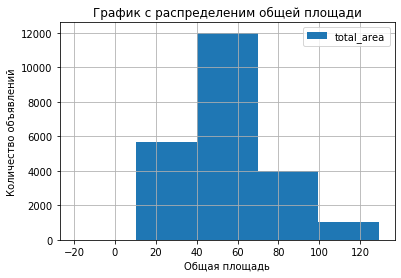

In [33]:
graphic(df, 'total_area')

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa217622210>,
 Text(0.5, 0, 'Цена'),
 Text(0, 0.5, 'Количество объявлений'))

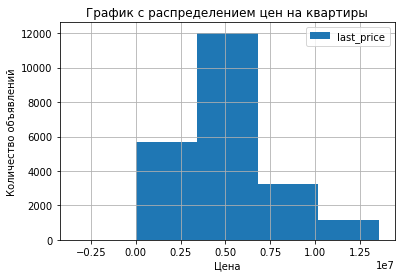

In [34]:
graphic(df, 'last_price')

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa21809c7d0>,
 Text(0.5, 0, 'Количество комнат'),
 Text(0, 0.5, 'Количество объявлений'))

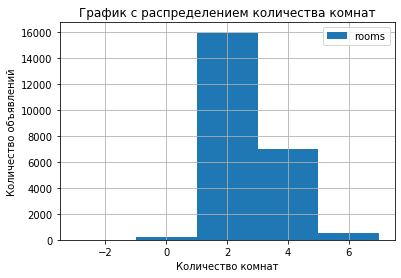

In [35]:
graphic(df, 'rooms')

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa217fa7e10>,
 Text(0.5, 0, 'Высота потолков'),
 Text(0, 0.5, 'Количество объявлений'))

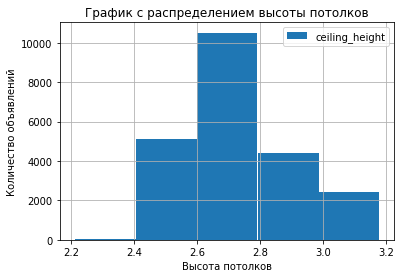

In [36]:
graphic(df, 'ceiling_height')

Вывод:
 - Большое число объявлений имеют площадь от 20 до 80. Чаще всего площадь квартиры составляет от 40 до 60 метров. 
 - Большинство квартир имеют стоимость от 3 500 000 до 5 000 000.
 - Основное кол-во квартир имеют от одной до трех комнат.
 - Большая часть квартир имеют высоту от 2.4 до 2.8 метров.

#### Изучим время продажи квартиры <a id='step4-2'></a>
Построим гистограмму, посчитаем среднее и медиану.

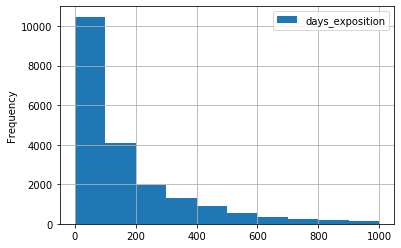

In [37]:
df['days_exposition'].plot(kind='hist',
y='column',
range=(0, 1000),
bins=10,
grid=True,
legend=True) 
plt.show()

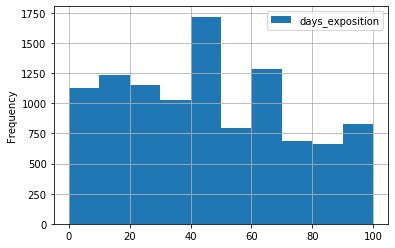

In [38]:
df['days_exposition'].plot(kind='hist',
y='column',
range=(0, 100),
bins=10,
grid=True,
legend=True) 
plt.show()

Большинство квартир продаются в течении 100 дней. Если смотреть более детально, то видно что чаще всего продажа случается через 40-50 дней. Есть предположение, что часть строк в данном столбце не заполнено, поскольку эти объявления до сих пор активны. 

In [39]:
df['days_exposition'].median()

95.0

In [40]:
df['days_exposition'].mean()

180.88483929357665

 #### Уберем редкие и выбивающиеся значения <a id='step4-3'></a>
  - высота потолков слишком низкая/высокая (1 и 100 метров соответственно)
  - высокая и низкая цена (763,000,000.00)
  - большое количество этажей в доме (60)
  - маленькая жилая площадь (12 метров)
 

In [41]:
df[['ceiling_height', 'last_price', 'floors_total', 'total_area']].describe()

,ceiling_height,last_price,floors_total,total_area
count,"23,612.00","23,613.00","23,613.00","23,613.00"
mean,2.77,"6,540,555.46",10.67,60.34
std,0.99,"10,901,722.74",6.60,35.65
min,1.00,"12,190.00",1.00,12.00
25%,2.60,"3,400,000.00",5.00,40.00
50%,2.71,"4,650,000.00",9.00,52.00
75%,2.79,"6,799,000.00",16.00,69.80
max,100.00,"763,000,000.00",60.00,900.00


In [42]:
df['ceiling_height'].sort_values()

22508     1.00
5693      1.20
16866     1.75
16383     2.00
11304     2.00
         ...  
21298    27.50
3138     32.00
22255    32.00
22785   100.00
11525      nan
Name: ceiling_height, Length: 23613, dtype: float16

In [43]:
df['last_price'].sort_values()

8765         12,190.00
17388       430,000.00
14849       430,000.00
16211       440,000.00
17607       450,000.00
             ...      
15589   300,000,000.00
1432    330,000,000.00
14645   401,300,000.00
19465   420,000,000.00
12917   763,000,000.00
Name: last_price, Length: 23613, dtype: float64

In [44]:
df['floors_total'].sort_values()

8308      1
5281      1
16952     1
17674     1
14774     1
         ..
5787     36
395      36
16866    37
16664    52
2247     60
Name: floors_total, Length: 23613, dtype: int16

In [45]:
df['total_area'].sort_values()        

19829    12.00
19471    13.00
19732    13.00
17890    13.00
19483    13.20
         ...  
5339    590.00
15589   618.00
3107    631.00
12805   631.20
19465   900.00
Name: total_area, Length: 23613, dtype: float64

Создадим функцию для удаления выбросов.

In [46]:
def delete_data(df, column,graphic=0,x=10,y=10):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    filter_data = (df[column] >= (q1 - 1.5*iqr)) & (df[column] <= (q3 + 1.5*iqr))
    if graphic == 1:
        return df.loc[filter_data].boxplot([column], figsize=(x,y))
    else:
        return df.loc[filter_data]

Применим функцию для выбранных столбцов.

(0, 150)

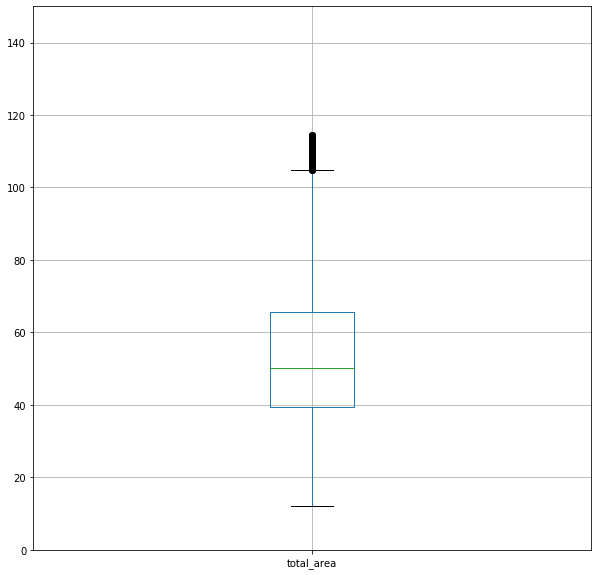

In [47]:
delete_data(df,'total_area',1,10,10).set_ylim(0,150)

Сравним данные после удаления с первоначальными.

In [48]:
delete_data(df,'total_area',0)['total_area'].mean()

54.34882681564246

In [49]:
df['total_area'].mean()


60.340678439842456

Проведем такую же операцию для других столбцов.

(2, 4)

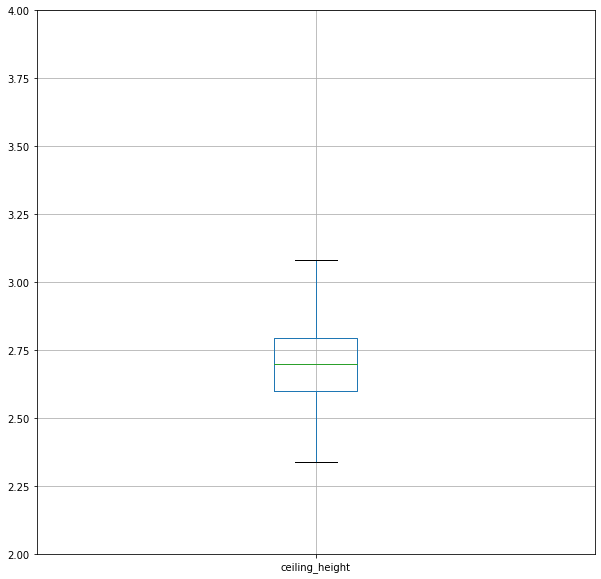

In [50]:
delete_data(df,'ceiling_height',1,10,10).set_ylim(2,4)

In [51]:
delete_data(df,'ceiling_height',0)['ceiling_height'].mean()

2.7

In [52]:
df['ceiling_height'].mean()

2.771

(0, 100000000)

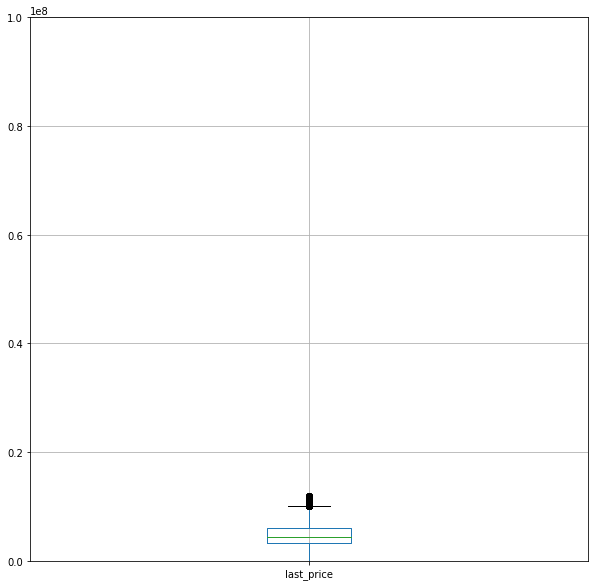

In [53]:
delete_data(df,'last_price',1,10,10).set_ylim(0,100000000)

In [54]:
delete_data(df,'last_price',0)['last_price'].mean()

4839129.226998702

In [55]:
df['last_price'].mean()

6540555.460890188

(15000, 200000)

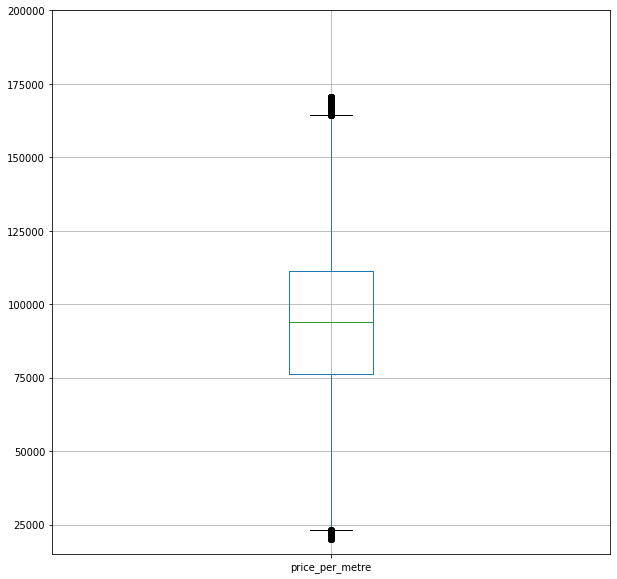

In [56]:
delete_data(df,'price_per_metre',1,10,10).set_ylim(15000,200000)

In [57]:
delete_data(df,'price_per_metre',0)['price_per_metre'].mean()

93728.03400585774

In [58]:
df['price_per_metre'].mean()

99397.48024028222

(0, 30)

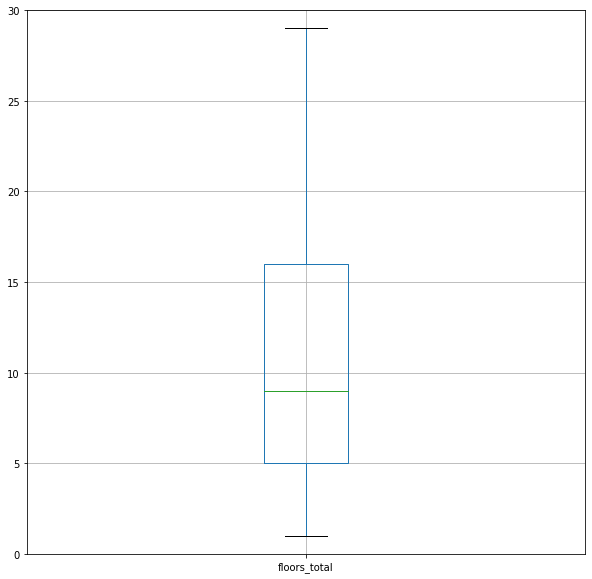

In [59]:
delete_data(df,'floors_total',1,10,10).set_ylim(0,30)

In [60]:
delete_data(df,'floors_total',0)['floors_total'].mean()

10.638946609558543

In [61]:
df['floors_total'].mean()

10.67382374115953

(0, 200)

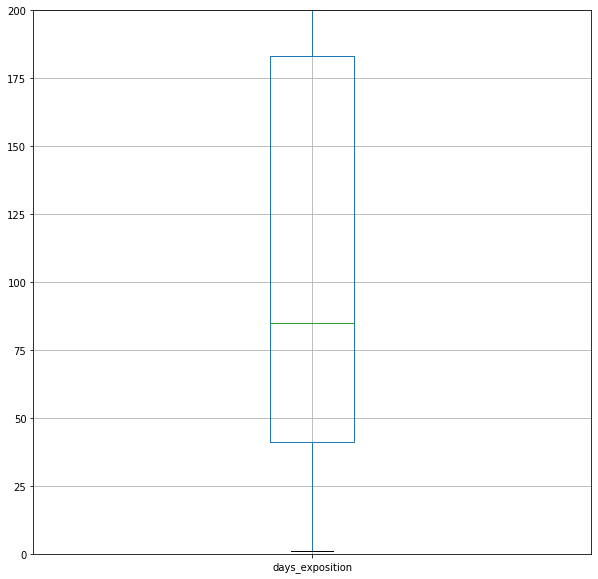

In [62]:
delete_data(df,'days_exposition',1,10,10).set_ylim(0,200)

In [63]:
delete_data(df,'days_exposition',0)['days_exposition'].mean()

128.76360634785388

In [64]:
df['days_exposition'].mean()

180.88483929357665

Создадим сводную таблицу со старыми и новыми данными

In [65]:
d = {'last_price': [df['last_price'].mean(), delete_data(df,'last_price',0)['last_price'].mean()], 
     'price_per_metre': [df['price_per_metre'].mean(), delete_data(df,'price_per_metre',0)['price_per_metre'].mean()], 
     'total_area': [df['total_area'].mean(), delete_data(df,'total_area',0)['total_area'].mean()], 
     'floors_total': [df['floors_total'].mean(), delete_data(df,'floors_total',0)['floors_total'].mean()], 
     'days_exposition': [df['days_exposition'].mean(), delete_data(df,'days_exposition',0)['days_exposition'].mean()], 
     'ceiling_height': [df['ceiling_height'].mean(), delete_data(df,'ceiling_height',0)['ceiling_height'].mean()],        
    }

df2 = pd.DataFrame(data=d)
df2.index = ['with_discharge', 'without_discharge'] 



In [66]:
display(df2)

,last_price,price_per_metre,total_area,floors_total,days_exposition,ceiling_height
with_discharge,"6,540,555.46","99,397.48",60.34,10.67,180.88,2.77
without_discharge,"4,839,129.23","93,728.03",54.35,10.64,128.76,2.70


Некоторые выбросы в датасете серьезно изменяли картину о средних показателей в следующих столбцах - стоимость, площадь, число дней публикации.

In [67]:
df = delete_data(df,'total_area',0)
df = delete_data(df,'last_price',0)
df = delete_data(df,'days_exposition',0)
df = delete_data(df,'ceiling_height',0)

In [68]:
df2.loc[2] = [df['last_price'].mean(), df['price_per_metre'].mean(), df['total_area'].mean(),df['floors_total'].mean(),
             df['days_exposition'].mean(),df['ceiling_height'].mean()]
df2.index = ['with_discharge', 'without_discharge','final_stat']
display(df2)

,last_price,price_per_metre,total_area,floors_total,days_exposition,ceiling_height
with_discharge,"6,540,555.46","99,397.48",60.34,10.67,180.88,2.77
without_discharge,"4,839,129.23","93,728.03",54.35,10.64,128.76,2.70
final_stat,"4,532,825.56","90,608.26",50.70,11.22,119.49,2.69


In [69]:
df.describe()

,days_exposition,year_exposition,last_price,price_per_metre,ceiling_height,floors_total,floor,rooms,balcony,total_area,...,kitchen_area,relation_living_total,relation_kitchen_total,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images
count,"16,242.00","16,242.00","16,242.00","16,242.00","16,242.00","16,242.00","16,242.00","16,242.00","16,242.00","16,242.00",...,"16,242.00","16,242.00","16,242.00","12,088.00","12,099.00","12,099.00","4,704.00","12,099.00","5,574.00","16,242.00"
mean,119.49,"2,017.38","4,532,825.56","90,608.26",2.69,11.22,6.10,1.84,0.61,50.70,...,9.23,0.56,0.19,"29,240.31","15,522.61",0.51,492.29,0.65,543.22,9.51
std,112.70,0.83,"1,913,923.76","28,052.86",0.14,6.71,5.00,0.86,0.93,16.45,...,3.47,0.10,0.07,"13,266.95","8,154.82",0.73,325.65,0.84,275.00,5.51
min,1.00,"2,015.00","12,190.00",111.83,2.34,1.00,1.00,0.00,0.00,12.00,...,2.00,0.04,0.04,0.00,329.00,0.00,1.00,0.00,16.00,0.00
25%,39.00,"2,017.00","3,250,000.00","74,358.97",2.60,5.00,2.00,1.00,0.00,38.00,...,6.90,0.50,0.14,"17,720.00","11,285.00",0.00,298.00,0.00,332.00,6.00
50%,76.00,"2,017.00","4,200,000.00","91,475.48",2.70,9.00,5.00,2.00,0.00,46.80,...,8.70,0.57,0.18,"27,893.00","13,994.00",0.00,459.00,0.00,534.00,9.00
75%,170.00,"2,018.00","5,550,000.00","107,022.70",2.79,16.00,8.00,2.00,1.00,60.60,...,10.85,0.63,0.23,"38,979.50","16,850.00",1.00,619.00,1.00,753.00,13.00
max,478.00,"2,019.00","10,700,000.00","312,240.00",3.08,60.00,33.00,6.00,5.00,114.50,...,50.00,1.00,0.79,"83,758.00","64,857.00",3.00,"3,190.00",3.00,"1,344.00",39.00


In [70]:
df = df.reset_index(drop= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Data columns (total 29 columns):
first_day_exposition      16242 non-null datetime64[ns]
days_exposition           16242 non-null float64
day_exposition            16242 non-null object
month_exposition          16242 non-null object
year_exposition           16242 non-null int64
last_price                16242 non-null float64
price_per_metre           16242 non-null float64
locality_name             16242 non-null object
is_apartment              16242 non-null bool
studio                    16242 non-null bool
open_plan                 16242 non-null bool
ceiling_height            16242 non-null float16
floors_total              16242 non-null int16
floor                     16242 non-null int16
category_floor            16242 non-null object
rooms                     16242 non-null int16
balcony                   16242 non-null int16
total_area                16242 non-null float64
living_area              

#### Изучим, какие факторы влияют на стоимость квартиры<a id='step4-4'></a>

In [71]:
station_stat_multi = df[['last_price','total_area', 'rooms', 'cityCenters_nearest']].corr()
display(station_stat_multi) 

,last_price,total_area,rooms,cityCenters_nearest
last_price,1.00,0.67,0.42,-0.31
total_area,0.67,1.00,0.81,-0.07
rooms,0.42,0.81,1.00,-0.04
cityCenters_nearest,-0.31,-0.07,-0.04,1.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa217c28310>,
      dtype=object)

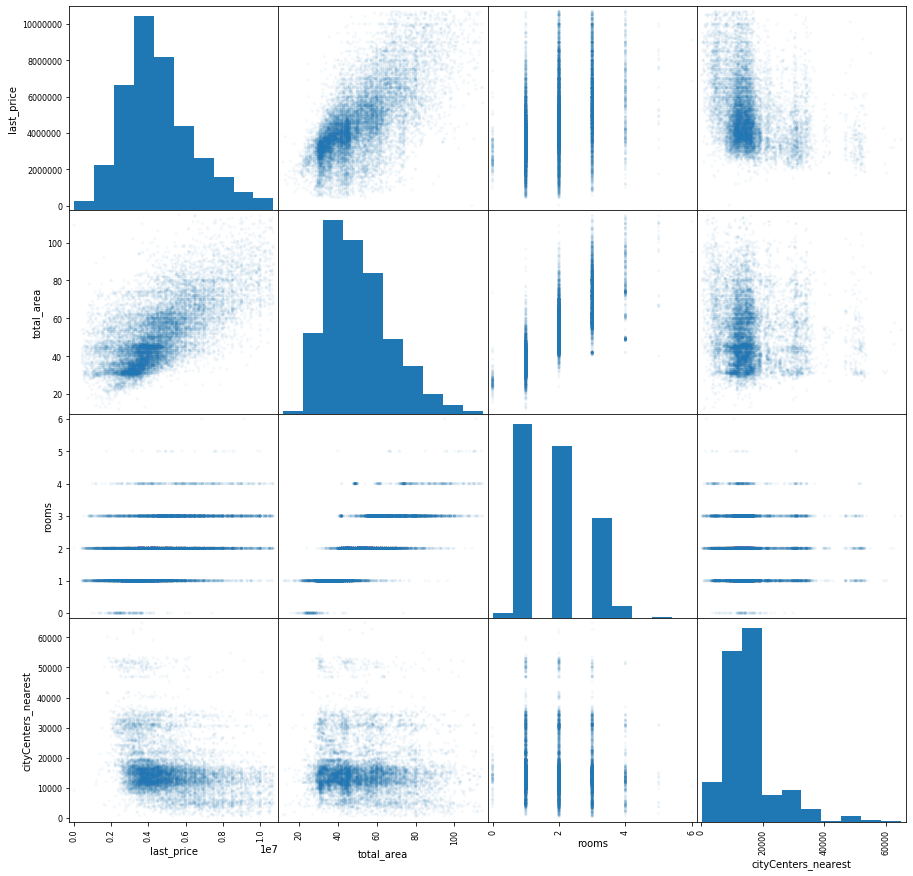

In [72]:
pd.plotting.scatter_matrix(df[['last_price','total_area', 'rooms', 'cityCenters_nearest']], figsize=(15, 15), alpha=0.05)

Цена зависит от площади, которая в свою очередь зависит от количества комнат. Удаленность от центра имеет также связь с ценой - чем ближе, тем дороже. 

Проверим зависимость в дате публикации.

(0, 10000000)

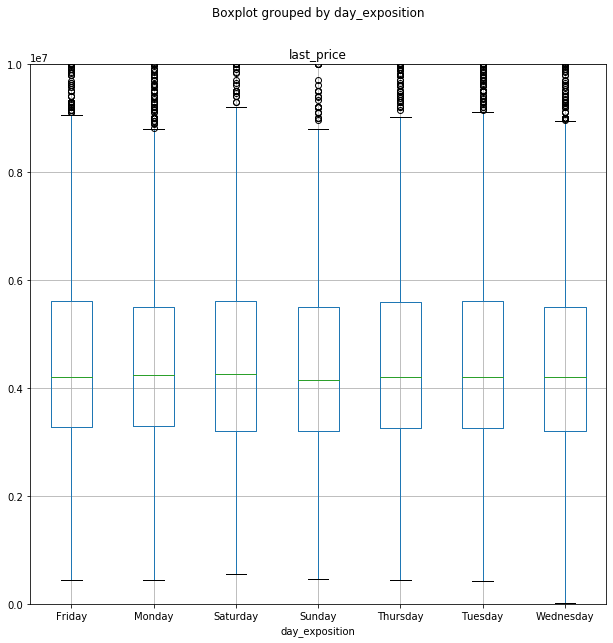

In [73]:
df.boxplot('last_price', by='day_exposition',figsize=(10,10))
plt.ylim(0, 10000000)

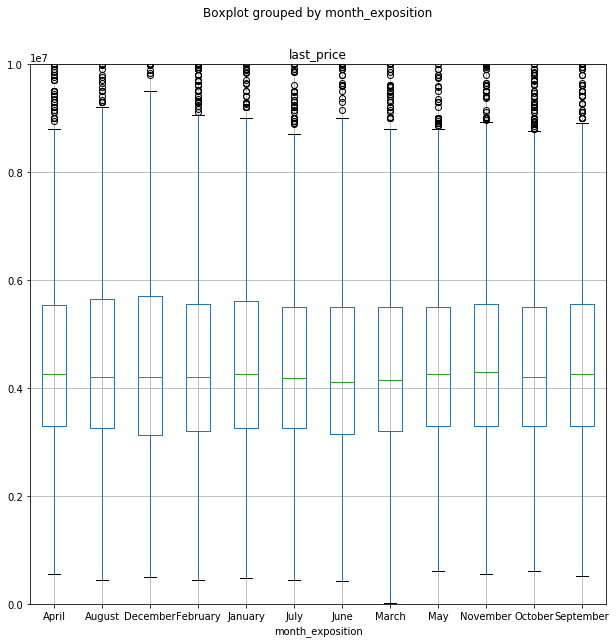

In [74]:
plot = df.boxplot('last_price', by='month_exposition',figsize=(10,10)).set_ylim(0,10000000)

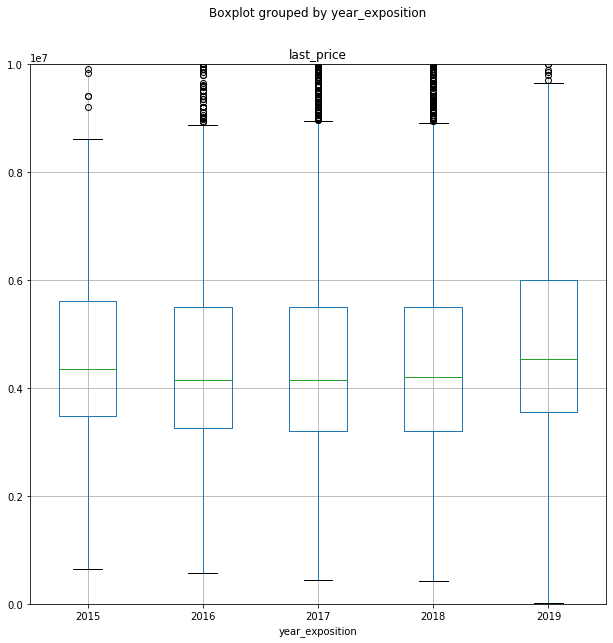

In [75]:
plot = df.boxplot('last_price', by='year_exposition',figsize=(10,10)).set_ylim(0,10000000)

Нет никаких связей между ценой квартиры и днем, месяцем и годом публикации. 
Единственное, что было замечено, это высокая стоиомсть жилья в 2014 году.

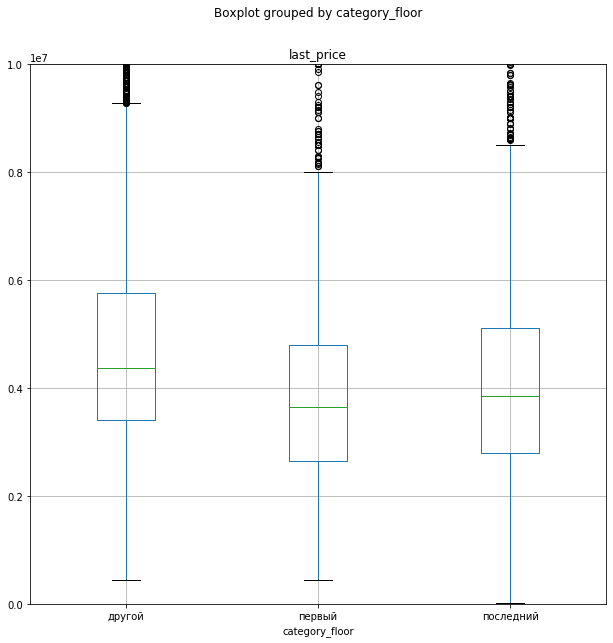

In [76]:
plot = df.boxplot('last_price', by='category_floor',figsize=(10,10)).set_ylim(0,10000000)


Стоимость квартиры на первом этаже ниже, чем на других этажах. Общеизвестный факт подтверждается статистикой. 

#### Выберем 10 населённых пунктов с наибольшим числом объявленийи и посчитаем среднюю цену кв. метра в них.<a id='step4-5'></a>

In [77]:
top10_locality = df['locality_name'].value_counts().head(10)
print(top10_locality)

санкт-петербург    10188
мурино               507
кудрово              398
шушары               368
всеволожск           293
парголово            283
колпино              280
пушкин               246
гатчина              233
выборг               174
Name: locality_name, dtype: int64


In [78]:
print(top10_locality.index)

Index(['санкт-петербург', 'мурино', 'кудрово', 'шушары', 'всеволожск',
       'парголово', 'колпино', 'пушкин', 'гатчина', 'выборг'],
      dtype='object')


In [79]:
top10 = (df
         .query('locality_name in @top10_locality.index')
         .pivot_table(index='locality_name', values='price_per_metre', aggfunc='mean')
) 
print(top10.info())
    

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, всеволожск to шушары
Data columns (total 1 columns):
price_per_metre    10 non-null float64
dtypes: float64(1)
memory usage: 160.0+ bytes
None


Объединим две таблицы в одну.

In [80]:
top10_city = pd.DataFrame({'locality_name':top10_locality.index, 'counts':top10_locality.values})
top10_city = top10_city.merge(top10, on='locality_name')


In [81]:
display(top10_city)

,locality_name,counts,price_per_metre
0,санкт-петербург,10188,"103,535.96"
1,мурино,507,"85,903.34"
2,кудрово,398,"94,398.87"
3,шушары,368,"77,720.69"
4,всеволожск,293,"66,465.78"
5,парголово,283,"89,174.26"
6,колпино,280,"74,594.74"
7,пушкин,246,"98,661.05"
8,гатчина,233,"68,075.18"
9,выборг,174,"57,104.68"


Как и ожидалось, больше всего объявлений с локацией Санкт-Петербург. В данном городе оказалась и самая высокая цена за метр.

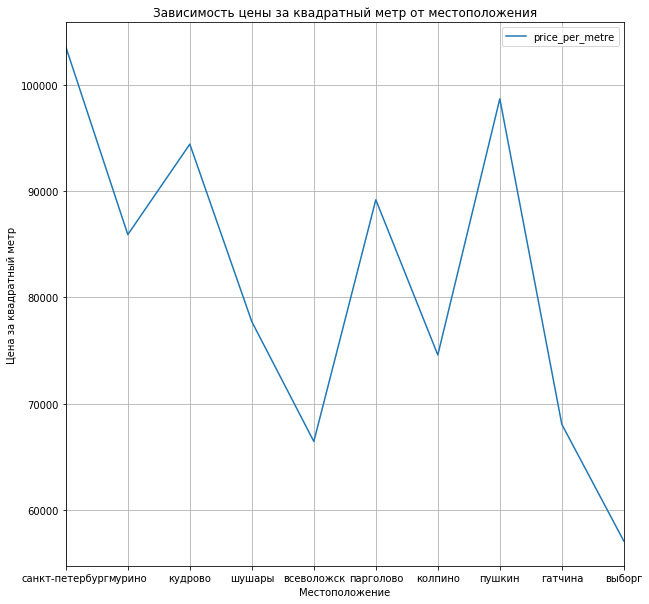

In [82]:
top10_city.plot(x='locality_name', y='price_per_metre', figsize=(10, 10), grid = True)
plt.title('Зависимость цены за квадратный метр от местоположения')
plt.xlabel('Местоположение')
plt.ylabel('Цена за квадратный метр')
plt.show()


#### Изучим предложения квартир в зависимости от расстояния до центра. <a id='step4-6'></a>
Сначала перевередем метры в километры. 

In [83]:
df['cityCenters_nearest'].value_counts()

15,985.00    20
10,337.00    20
17,256.00    17
13,845.00    17
14,883.00    16
             ..
18,418.00     1
12,655.00     1
15,236.00     1
11,205.00     1
15,645.00     1
Name: cityCenters_nearest, Length: 5801, dtype: int64

In [84]:
df['cityCenters_nearest_km'] = (df['cityCenters_nearest']/1000).round(0)

In [85]:
df['cityCenters_nearest_km'].value_counts()

12.00    1241
15.00    1204
13.00    1111
16.00    1005
14.00     992
11.00     848
17.00     700
10.00     521
9.00      382
8.00      319
19.00     306
18.00     298
5.00      276
6.00      258
31.00     236
4.00      214
7.00      189
22.00     170
30.00     166
34.00     138
21.00     124
32.00     105
33.00     102
20.00      96
29.00      93
3.00       92
24.00      91
26.00      88
23.00      87
28.00      79
27.00      73
2.00       67
25.00      64
35.00      61
1.00       43
52.00      42
50.00      41
51.00      30
36.00      28
47.00      23
53.00      18
49.00      17
40.00      11
37.00      11
41.00       8
48.00       7
42.00       5
0.00        4
54.00       3
60.00       2
39.00       2
43.00       1
45.00       1
63.00       1
65.00       1
59.00       1
61.00       1
55.00       1
62.00       1
Name: cityCenters_nearest_km, dtype: int64

Выберем объявления с необходимым расположением.

In [86]:
center_spb = df.query('locality_name =="санкт-петербург"')

Посмотрим, как изменяется цена в зависимости от удаленности.

In [87]:
center_spb_group_km = center_spb.groupby('cityCenters_nearest_km')['price_per_metre'].median()

In [88]:
center_spb_group_km

cityCenters_nearest_km
0.00    104,081.63
1.00    111,007.46
2.00    108,404.38
3.00    102,030.93
4.00    111,111.11
5.00    122,313.15
6.00    116,354.69
7.00    112,774.45
8.00    109,523.81
9.00    102,631.58
10.00   103,390.80
11.00   100,725.95
12.00   102,064.22
13.00   102,162.16
14.00   100,495.88
15.00    99,174.86
16.00    96,052.63
17.00    93,513.32
18.00    92,920.35
19.00    96,622.27
20.00   104,000.00
21.00    87,389.79
22.00    88,014.98
23.00    88,582.83
24.00    86,184.84
25.00    94,324.32
26.00    87,614.21
27.00    70,312.50
28.00    79,372.09
29.00    67,601.28
Name: price_per_metre, dtype: float64

In [89]:
center_spb['cityCenters_nearest_km'].describe()

count   10,173.00
mean        12.81
std          4.17
min          0.00
25%         11.00
50%         13.00
75%         15.00
max         29.00
Name: cityCenters_nearest_km, dtype: float64

Построи график зависимости удаленности, от медианной стоимости

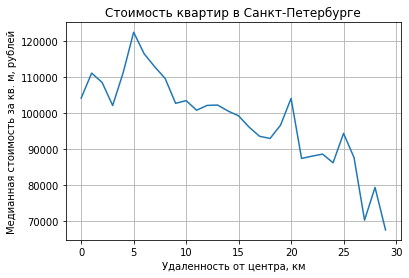

In [90]:
plt.plot(center_spb_group_km)
plt.xlim=10
plt.title('Стоимость квартир в Санкт-Петербурге')
plt.ylabel('Медианная стоимость за кв. м, рублей')
plt.xlabel('Удаленность от центра, км')
plt.grid()
plt.show()

Центральная зона города находится в радиусе 8 км. Стоимость квадратного метра на данной границе составляет ~ 122 тыс. При удаленности от центра а 9 км, стоимость уже составляет ~105 тыс.
Стоит также отметить, что имеются выбросы данных (большая цена за метр при удаленности в 27 км). 

#### Рассмотрим центральный сегмент подробнее<a id='step4-6'></a>

In [91]:
central_segment = center_spb.query('cityCenters_nearest_km <= 8.00')

In [92]:
central_segment.describe()

,days_exposition,year_exposition,last_price,price_per_metre,ceiling_height,floors_total,floor,rooms,balcony,total_area,...,relation_living_total,relation_kitchen_total,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,cityCenters_nearest_km
count,"1,457.00","1,457.00","1,457.00","1,457.00","1,457.00","1,457.00","1,457.00","1,457.00","1,457.00","1,457.00",...,"1,457.00","1,457.00","1,456.00","1,457.00","1,457.00",839.00,"1,457.00","1,018.00","1,457.00","1,457.00"
mean,126.09,"2,017.31","6,577,028.67","117,023.24",2.79,8.09,4.48,2.06,0.35,58.35,...,0.57,0.18,"25,191.35","5,596.34",0.81,498.45,1.16,495.89,9.32,5.55
std,115.29,0.85,"1,955,482.90","28,863.08",0.16,4.78,3.36,0.89,0.74,19.21,...,0.11,0.07,"5,930.02","1,947.15",0.85,331.22,1.02,262.75,5.55,1.93
min,3.00,"2,015.00","1,600,000.00","17,391.30",2.40,2.00,1.00,0.00,0.00,12.00,...,0.04,0.06,"11,477.00",329.00,0.00,11.00,0.00,22.00,0.00,0.00
25%,37.00,"2,017.00","5,100,000.00","96,322.24",2.70,5.00,2.00,1.00,0.00,43.60,...,0.51,0.13,"20,898.25","4,303.00",0.00,305.50,0.00,282.25,5.00,4.00
50%,86.00,"2,017.00","6,500,000.00","112,278.48",2.79,6.00,4.00,2.00,0.00,56.40,...,0.57,0.17,"24,457.50","5,660.00",1.00,454.00,1.00,480.00,9.00,6.00
75%,184.00,"2,018.00","8,000,000.00","133,571.43",2.95,10.00,5.00,3.00,0.00,72.00,...,0.65,0.21,"29,694.00","7,316.00",1.00,611.00,2.00,702.25,13.00,7.00
max,477.00,"2,019.00","10,700,000.00","292,307.69",3.08,28.00,22.00,6.00,5.00,114.20,...,0.90,0.55,"44,754.00","8,499.00",3.00,"2,295.00",3.00,"1,199.00",32.00,8.00


In [93]:
df.describe()

,days_exposition,year_exposition,last_price,price_per_metre,ceiling_height,floors_total,floor,rooms,balcony,total_area,...,relation_living_total,relation_kitchen_total,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,cityCenters_nearest_km
count,"16,242.00","16,242.00","16,242.00","16,242.00","16,242.00","16,242.00","16,242.00","16,242.00","16,242.00","16,242.00",...,"16,242.00","16,242.00","12,088.00","12,099.00","12,099.00","4,704.00","12,099.00","5,574.00","16,242.00","12,099.00"
mean,119.49,"2,017.38","4,532,825.56","90,608.26",2.69,11.22,6.10,1.84,0.61,50.70,...,0.56,0.19,"29,240.31","15,522.61",0.51,492.29,0.65,543.22,9.51,15.52
std,112.70,0.83,"1,913,923.76","28,052.86",0.14,6.71,5.00,0.86,0.93,16.45,...,0.10,0.07,"13,266.95","8,154.82",0.73,325.65,0.84,275.00,5.51,8.16
min,1.00,"2,015.00","12,190.00",111.83,2.34,1.00,1.00,0.00,0.00,12.00,...,0.04,0.04,0.00,329.00,0.00,1.00,0.00,16.00,0.00,0.00
25%,39.00,"2,017.00","3,250,000.00","74,358.97",2.60,5.00,2.00,1.00,0.00,38.00,...,0.50,0.14,"17,720.00","11,285.00",0.00,298.00,0.00,332.00,6.00,11.00
50%,76.00,"2,017.00","4,200,000.00","91,475.48",2.70,9.00,5.00,2.00,0.00,46.80,...,0.57,0.18,"27,893.00","13,994.00",0.00,459.00,0.00,534.00,9.00,14.00
75%,170.00,"2,018.00","5,550,000.00","107,022.70",2.79,16.00,8.00,2.00,1.00,60.60,...,0.63,0.23,"38,979.50","16,850.00",1.00,619.00,1.00,753.00,13.00,17.00
max,478.00,"2,019.00","10,700,000.00","312,240.00",3.08,60.00,33.00,6.00,5.00,114.50,...,1.00,0.79,"83,758.00","64,857.00",3.00,"3,190.00",3.00,"1,344.00",39.00,65.00


In [94]:
data_compare = {'last_price': [central_segment['last_price'].mean(), delete_data(df,'last_price',0)['last_price'].mean()], 
     'price_per_metre': [central_segment['price_per_metre'].mean(), delete_data(df,'price_per_metre',0)['price_per_metre'].mean()], 
     'total_area': [central_segment['total_area'].mean(), delete_data(df,'total_area',0)['total_area'].mean()], 
     'floors_total': [central_segment['floors_total'].mean(), delete_data(df,'floors_total',0)['floors_total'].mean()], 
     'days_exposition': [central_segment['days_exposition'].mean(), delete_data(df,'days_exposition',0)['days_exposition'].mean()], 
     'ceiling_height': [central_segment['ceiling_height'].mean(), delete_data(df,'ceiling_height',0)['ceiling_height'].mean()],        
     'rooms': [central_segment['rooms'].mean(), delete_data(df,'rooms',0)['rooms'].mean()],                  
    }

df3 = pd.DataFrame(data=data_compare)
df3.index = ['center', 'other'] 

display(df3)

,last_price,price_per_metre,total_area,floors_total,days_exposition,ceiling_height,rooms
center,"6,577,028.67","117,023.24",58.35,8.09,126.09,2.79,2.06
other,"4,377,559.82","90,372.03",49.95,11.19,102.07,2.69,1.78


Очевидно, что стоимость жилья в центре значительно выше, чем квартиры в других районах. Средняя цена квартиры больше практически в 3 раза, количество комнат и площадь также больше. Поскольку жилье стоит дороже, то и продается оно - дольше (практически в два раза).

In [95]:
central_segment_stat_multi = central_segment[['last_price', 
                                              'rooms',
                                              'floor', 
                                              'cityCenters_nearest_km', 
                                              'days_exposition']].corr()
display(central_segment_stat_multi) 

,last_price,rooms,floor,cityCenters_nearest_km,days_exposition
last_price,1.00,0.43,0.15,-0.20,0.11
rooms,0.43,1.00,-0.17,-0.19,0.07
floor,0.15,-0.17,1.00,0.27,-0.02
cityCenters_nearest_km,-0.20,-0.19,0.27,1.00,-0.07
days_exposition,0.11,0.07,-0.02,-0.07,1.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2145c3810>,
      dtype=object)

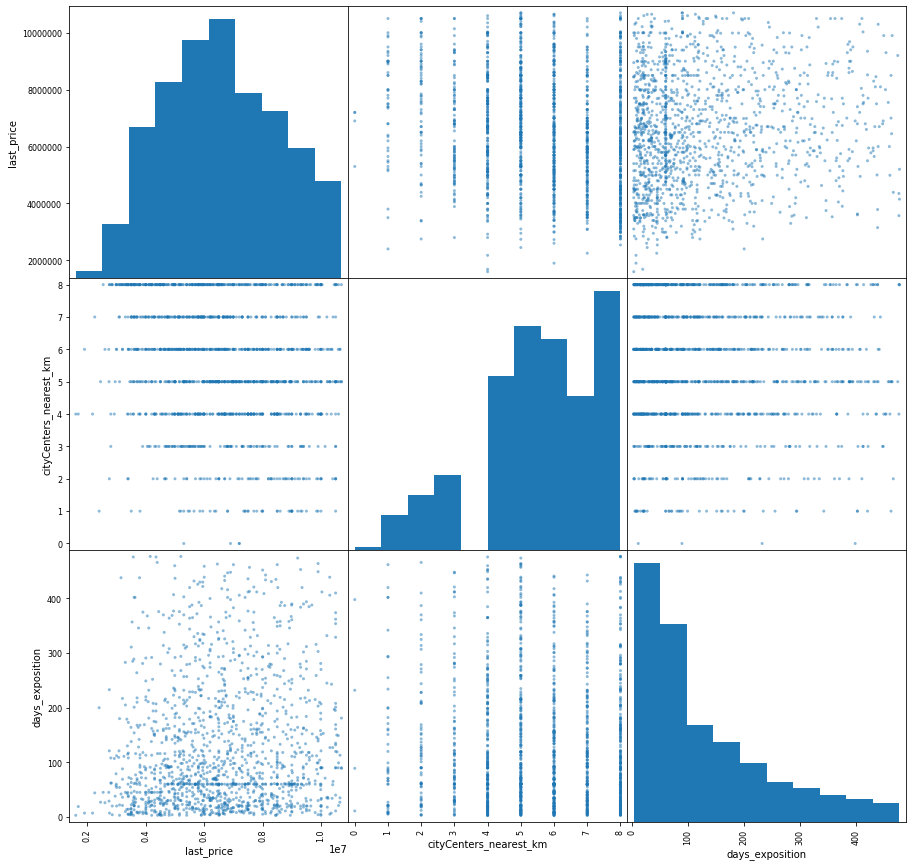

In [96]:
pd.plotting.scatter_matrix(central_segment[['last_price', 'cityCenters_nearest_km','days_exposition']], figsize=(15, 15), alpha=0.5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa214366750>,
      dtype=object)

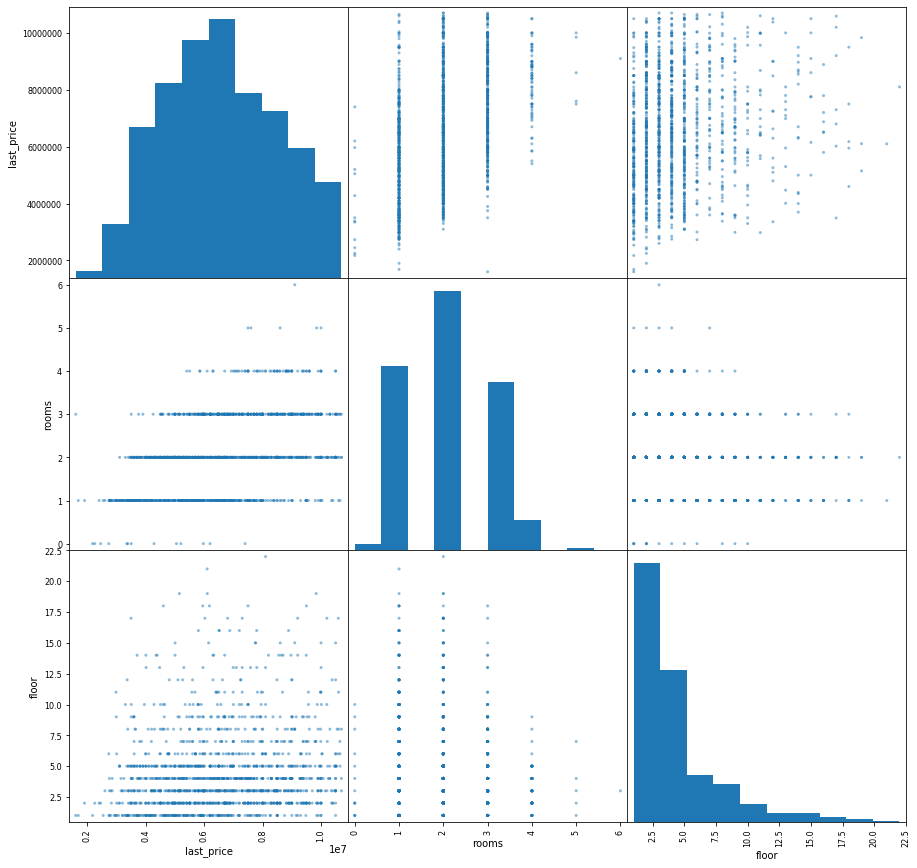

In [97]:
pd.plotting.scatter_matrix(central_segment[['last_price', 'rooms','floor']], figsize=(15, 15), alpha=0.5)

В целом картина по зависимостям схожа с общими данными.  

### Шаг 5. Общий вывод<a id='step5'></a>

Полученный датасет имел очень много пустых значений, которые мешали корректному анализу данных. В результате обработки данных:
 - пропущенные данные в столбце с количеством балконов заменены на 0
 - пропущенные значения для жилой и кухонной площади заменены на  средний показатель их зависимости от общей площади
 - удалены строки с отсутствующим местоположением.
Некоторые столбцы заменить подходящими значениями было невозможно, например ponds_around3000, ponds_nearest и др, поэтому желательно, чтобы датасет предварительно проверяли на полное заполнение всех столбцов.

Чтобы установить, какие факторы, влияют на стоимость квартиры, был проделан ряд исследований. На выходе мы получили, что на стоимость квартиры влияют:
 - район
 - удаленность от центра
 - площадь
 - количество комнат
 - этаж

Квартиры в центре Петербурга (в радиусе 8 км) стоят значительно дороже,чем в других районах. Средняя стоимость жилья в центре составляет 6,577,028, в то время как в других районах  - 4,377,559. Средняя цена за метр - 117 тысяч рублей. Жилье в центре Петербурга также отличается площадью - оно больше почти на 9 кв. метров, и составляет 58,35 м.кв.

Среди популярных местоположений стоит отметить Выборг, поскольку в данном районе стоимость квадратного метра всех меньше. А вот Пушкин, Кудрово и Мурино идут следом после северной столицы.
